In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install patool

     |████████████████████████████████| 77 kB 3.8 MB/s 


#TQDM Mode


In [ ]:
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/nftt2048hop512bins128.rar", outdir="/content")

patool: Extracting /content/drive/MyDrive/nftt2048hop512bins128.rar ...
patool: running /usr/bin/unrar x -- /content/drive/MyDrive/nftt2048hop512bins128.rar
patool:     with cwd='/content'
patool: ... /content/drive/MyDrive/nftt2048hop512bins128.rar extracted to `/content'.


'/content'

In [ ]:

"""
Authors : Rayane KADEM
In This program we use transfer learning with a pretrained vgg16model CNN model. We set the last 4
layers of the convolutional block to be re-trained, and we add 3 fully connected layers for the 
classifciation block. Vgg16 was trained previously on the well known ImageNet dataset. 
The presented architecture is inspired from a work of transfer learning for the task of writer 
identification with handwritten documents and yielded very promessing results. Which led us to test it
on the matter at hand.
"""

# Importing the required libraries
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import keras
from keras.layers import Flatten, Dense, Dropout, Conv2D, Activation ,MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping
from fetch_multi_spec_dataset import prep_data_images


In [ ]:
data = prep_data_images()
#data.prep_data("/content/mfcc",(224,124))
data.prep_data("/content/data",None,"melspectrogram","chroma_cqt","chroma_stft",1,0.2,0.2)

  0%|          | 0/10 [00:00<?, ?it/s]

disco



 10%|█         | 1/10 [00:01<00:16,  1.88s/it]

jazz



 20%|██        | 2/10 [00:03<00:14,  1.83s/it]

reggae



 30%|███       | 3/10 [00:05<00:12,  1.80s/it]

pop



 40%|████      | 4/10 [00:07<00:10,  1.79s/it]

hiphop



 50%|█████     | 5/10 [00:09<00:09,  1.81s/it]

rock



 60%|██████    | 6/10 [00:10<00:07,  1.78s/it]

classical



 70%|███████   | 7/10 [00:12<00:05,  1.84s/it]

blues



 80%|████████  | 8/10 [00:14<00:03,  1.84s/it]

metal



 90%|█████████ | 9/10 [00:16<00:01,  1.81s/it]

country



100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


In [ ]:
width,height,dimension = data.Xtest[0].shape

In [ ]:
width,height,dimension

(288, 432, 3)

In [ ]:
x= data.Xtest[0]

In [ ]:
x[:,:,0].mean()

0.3792

In [ ]:
x[:,:,1].mean()

0.1284

In [ ]:
x[:,:,2].mean()

0.142

## Transfer learning Vgg16

In [ ]:
# Defining the black box model
class CNNModel:
    def __init__(self):
        self.model = None
        self.model_name = "transfer_learning_vgg16_model_mel_chroma_stft_cqt_adam_ponderated_07_02_05"
        self.model_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + ".h5"
        self.model_weights_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+  self.model_name + "_weights.h5"
        self.model_history_path_acc = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_acc.png"
        self.model_history_path_loss = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_loss.png"
        
        self.model_history = None
    
    def build_model(self):
        """
        This function is used to create the black box model :
        """
        # Defining the input layer
        
        model = Sequential()

        vggmodel=VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(width,height,dimension), pooling=None)
        
        # Take all weights of imagenet dataset except for last four layers
        for layer in vggmodel.layers[:-4]: 
            layer.trainable = False 

        x = vggmodel.output
        x = Flatten()(x)
        
        x = Dense(512, activation="relu")(x)
        x = Dropout(0.5)(x)
        
        x = Dense(128, activation="elu")(x)
        
        predictions = Dense(10, activation="softmax")(x)

        # creating the final model 
        model = Model( vggmodel.input, predictions)
        model.summary()
        # Compiling the model
        self.model = model
        
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss = "categorical_crossentropy", metrics=['accuracy'])
        
    def train_model(self,data, epochs=10):
        """
        This function is used to train the black box model :
        """
        # Training the model
        self.model_history = self.model.fit(data.Xtrain,data.ytrain, epochs=epochs,validation_data=(data.Xval,data.yval), shuffle=True)
        
    def save_model(self):
        """
        This function is used to save the black box model :
        """
        # Save the model
        self.model.save(self.model_path)
        
    def load_model(self):
        """
        This function is used to load the black box model :
        """
        # Load the model
        self.model = tf.keras.models.load_model(self.model_path)
        
    def save_model_weights(self):
        """
        This function is used to save the weights of the black box model :
        """
        # Save the weights
        self.model.save_weights(self.model_weights_path)
    

    def evaluate_model(self, Xtest,ytest):
        """
        This function is used to evaluate the black box model :
        """
        # Evaluate the model
        test_loss, test_acc = self.model.evaluate(Xtest,ytest)
        print("Test loss: ", test_loss)
        print("Test accuracy: ", test_acc)
    
    def plot_model_history(self):
        """
        This function is used to plot the model history :
        """
        #define variables
        loss = self.model_history.history['loss']
        val_loss = self.model_history.history['val_loss']
        accuracy = self.model_history.history['accuracy']
        val_accuracy = self.model_history.history['val_accuracy']
        epochs = range(1, len(loss) + 1)
        # Plot the model history
        plt.figure()
        plt.plot(epochs, accuracy, label='Training accuracy')
        plt.plot(epochs, val_accuracy, label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.savefig(self.model_history_path_acc)
        plt.show()

        plt.figure()
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.savefig(self.model_history_path_loss)
        plt.show()
        
    def predict_class(self, spectrogram_image):
        """
        This function is used to predict the class of the spectrogram image :
        """
        # Predict the class
        prediction = self.model.predict(spectrogram_image)
        return np.argmax(prediction)

    def predict_classes(self, spectrogram_images):
        """
        This function is used to predict the classes of the spectrogram images :
        """
        # Predict the classes
        predictions = self.model.predict(spectrogram_images)
        return np.argmax(predictions, axis=1)

    
    def plot_confusion_matrix(self, Xtest,ytest, classes=None):
        """
        This function is used to plot the confusion matrix :
        """
        # Predict the classes
        predictions = self.predict_classes(Xtest)
        # Plot the confusion matrix
        y_parse = np.argmax(ytest, axis=1)
        cm = confusion_matrix(y_parse, predictions)
        #if classes is None:
        #    classes = test_generator.class_indices.keys()
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(10)
        plt.xticks(tick_marks,classes,  rotation=45)
        plt.yticks(tick_marks,classes)
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig("/content/drive/MyDrive/Mymodels_result/"+ self.model_name +"/"+"confusion_matrix.png")
        plt.show()
        acc = np.diag(cm).sum() /cm.sum()
        print("acc",acc)

In [ ]:
if __name__ == "__main__":
      # Create the  model
  model = CNNModel()
      
      # Build the  model
  model.build_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 288, 432, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 288, 432, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 288, 432, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 144, 216, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 144, 216, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 144, 216, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 72, 108, 128)      0     

In [ ]:
if __name__ == "__main__":
      # Create the  model
  model = CNNModel()
      
      # Build the  model
  model.build_model()
      # Train the  model
  model.train_model(data, epochs=70)
      
      # Save the  model
  model.save_model()

      # Evaluate  model
  model.evaluate_model(data.Xtest,data.ytest)

      # Plot the model history
  model.plot_model_history()
      
      # Plot the confusion matrix
  model.plot_confusion_matrix(data.Xtest,data.ytest)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 288, 432, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 288, 432, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 288, 432, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 144, 216, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 144, 216, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 144, 216, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 72, 108, 128)      0   

In [ ]:
model.evaluate_model(data.Xtest,data.ytest)

7/7 [==============================] - 4s 545ms/step - loss: 2.5400 - accuracy: 0.6150
Test loss:  2.5399575233459473
Test accuracy:  0.6150000095367432


In [ ]:
model.model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 288, 432, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 288, 432, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 288, 432, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 144, 216, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 144, 216, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 144, 216, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 72, 108, 128)      0   

In [ ]:
# Extractor 
extractor = Model(model.model.input, model.model.layers[-5].output)

In [ ]:
xtest_features= extractor.predict(data.Xtest)

In [ ]:
xtest_features.shape

(200, 59904)

## 2 Layers CNN model 

In [ ]:
width,height,dimenstion = data.Xtrain[0].shape

In [ ]:
# Defining the black box model
class CNNModel:
    def __init__(self):
        self.model = None
        self.model_name = "2layersCNN_ADAM_crossEn_chroma_stft_cqt_mel_ADAM_CrossEnt_ponderated_07_02_05"
        self.model_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + ".h5"
        self.model_weights_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+  self.model_name + "_weights.h5"
        self.model_history_path_acc = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_acc.png"
        self.model_history_path_loss = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_loss.png"
        
        self.model_history = None
    
    def build_model(self):
        """
        This function is used to create the black box model :
        """
        # Defining the input layer
        
        model = Sequential()

        #Adding the CNN layers along with some drop outs and maxpooling
        
        model.add(Conv2D(64, (3,3), activation ='relu', input_shape =(width,height,dimension)))
        model.add(MaxPooling2D(pool_size = (2,2)))


        model.add(Conv2D(32, (3,3),strides=(1,1) , activation = 'relu'))
        model.add(MaxPooling2D(pool_size = (2,2)))
        
        model.add(Flatten())

        
        #Adding the dense layers
        model.add(Dense(256, activation = 'relu'))
        model.add(Dropout(0.5))
        model.add(Dense(124, activation = 'relu'))
        #final output layer with 10 predictions to be made
        model.add(Dense(10, activation = 'softmax'))
    
        
        
        # Compiling the model
        self.model = model
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

    def train_model(self,data, epochs=10):
        """
        This function is used to train the black box model :
        """
        # Training the model
        self.model_history = self.model.fit(data.Xtrain,data.ytrain, epochs=epochs,validation_data=(data.Xval,data.yval), shuffle=True)
        
    def save_model(self):
        """
        This function is used to save the black box model :
        """
        # Save the model
        self.model.save(self.model_path)
        
    def load_model(self):
        """
        This function is used to load the black box model :
        """
        # Load the model
        self.model = tf.keras.models.load_model(self.model_path)
        
    def save_model_weights(self):
        """
        This function is used to save the weights of the black box model :
        """
        # Save the weights
        self.model.save_weights(self.model_weights_path)
    

    def evaluate_model(self, Xtest,ytest):
        """
        This function is used to evaluate the black box model :
        """
        # Evaluate the model
        test_loss, test_acc = self.model.evaluate(Xtest,ytest)
        print("Test loss: ", test_loss)
        print("Test accuracy: ", test_acc)
    
    def plot_model_history(self):
        """
        This function is used to plot the model history :
        """
        #define variables
        loss = self.model_history.history['loss']
        val_loss = self.model_history.history['val_loss']
        accuracy = self.model_history.history['accuracy']
        val_accuracy = self.model_history.history['val_accuracy']
        epochs = range(1, len(loss) + 1)
        # Plot the model history
        plt.figure()
        plt.plot(epochs, accuracy, label='Training accuracy')
        plt.plot(epochs, val_accuracy, label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.savefig(self.model_history_path_acc)
        plt.show()

        plt.figure()
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.savefig(self.model_history_path_loss)
        plt.show()
        
    def predict_class(self, spectrogram_image):
        """
        This function is used to predict the class of the spectrogram image :
        """
        # Predict the class
        prediction = self.model.predict(spectrogram_image)
        return np.argmax(prediction)

    def predict_classes(self, spectrogram_images):
        """
        This function is used to predict the classes of the spectrogram images :
        """
        # Predict the classes
        predictions = self.model.predict(spectrogram_images)
        return np.argmax(predictions, axis=1)

    
    def plot_confusion_matrix(self, Xtest,ytest, classes=None):
        """
        This function is used to plot the confusion matrix :
        """
        # Predict the classes
        predictions = self.predict_classes(Xtest)
        # Plot the confusion matrix
        y_parse = np.argmax(ytest, axis=1)
        cm = confusion_matrix(y_parse, predictions)
        #if classes is None:
        #    classes = test_generator.class_indices.keys()
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(10)
        plt.xticks(tick_marks,classes,  rotation=45)
        plt.yticks(tick_marks,classes)
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig("/content/drive/MyDrive/Mymodels_result/"+ self.model_name +"/"+"confusion_matrix.png")
        plt.show()
        acc = np.diag(cm).sum() /cm.sum()
        print("acc",acc)

In [ ]:
for i in range(1):
    
    # Fetch the training and test dataset
    
    # Create the  model
    model = CNNModel()
    
    # Build the  model
    model.build_model()
    # Train the  model
    model.train_model(data, epochs=300)
    
    # Save the  model
    model.save_model()

    # Evaluate  model
    model.evaluate_model(data.Xtest,data.ytest)

    # Plot the model history
    model.plot_model_history()
    
    # Plot the confusion matrix
    model.plot_confusion_matrix(data.Xtest,data.ytest)


Epoch 1/300
 1/22 [>.............................] - ETA: 1:19 - loss: 2.3017 - accuracy: 0.0625

KeyboardInterrupt: ignored

## 3 Layers CNN model 

In [ ]:
width,height,dimenstion = data.Xtrain[0].shape

In [ ]:
# Defining the black box model
class CNNModel:
    def __init__(self):
        self.model = None
        #self.model_name = "3layersCNN_ADAM_crossEn_chroma_stft_cqt_mel_ADAM_CrossEnt_ponderated_07_02_02"
        self.model_name = "2layersCNN_trial"
        self.model_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + ".h5"
        self.model_weights_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+  self.model_name + "_weights.h5"
        self.model_history_path_acc = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_acc.png"
        self.model_history_path_loss = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_loss.png"
        
        self.model_history = None
    
    def build_model(self):
        """
        This function is used to create the black box model :
        """
        # Defining the input layer
        
        model = Sequential()

        #Adding the CNN layers along with some drop outs and maxpooling
        
        model.add(Conv2D(64, (3,3), activation ='relu', input_shape =(width,height,dimension)))
        model.add(MaxPooling2D(pool_size = (2,2)))


        model.add(Conv2D(32, (3,3), activation = 'relu'))
        model.add(MaxPooling2D(pool_size = (2,2)))
        
        
        model.add(Flatten())

        
        #Adding the dense layers
        
        model.add(Dense(256, activation = 'relu'))
        model.add(Dropout(0.5))
        
        model.add(Dense(124, activation = 'relu'))
        #final output layer with 10 predictions to be made
        model.add(Dense(10, activation = 'softmax'))
    
        
        
        # Compiling the model
        self.model = model
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    def train_model(self,data, epochs=10):
        """
        This function is used to train the black box model :
        """
        # Training the model
        self.model_history = self.model.fit(data.Xtrain,data.ytrain, epochs=epochs,validation_data=(data.Xval,data.yval), shuffle=True)
        
    def save_model(self):
        """
        This function is used to save the black box model :
        """
        # Save the model
        self.model.save(self.model_path)
        
    def load_model(self):
        """
        This function is used to load the black box model :
        """
        # Load the model
        self.model = tf.keras.models.load_model(self.model_path)
        
    def save_model_weights(self):
        """
        This function is used to save the weights of the black box model :
        """
        # Save the weights
        self.model.save_weights(self.model_weights_path)
    

    def evaluate_model(self, Xtest,ytest):
        """
        This function is used to evaluate the black box model :
        """
        # Evaluate the model
        test_loss, test_acc = self.model.evaluate(Xtest,ytest)
        print("Test loss: ", test_loss)
        print("Test accuracy: ", test_acc)
    
    def plot_model_history(self):
        """
        This function is used to plot the model history :
        """
        #define variables
        loss = self.model_history.history['loss']
        val_loss = self.model_history.history['val_loss']
        accuracy = self.model_history.history['accuracy']
        val_accuracy = self.model_history.history['val_accuracy']
        epochs = range(1, len(loss) + 1)
        # Plot the model history
        plt.figure()
        plt.plot(epochs, accuracy, label='Training accuracy')
        plt.plot(epochs, val_accuracy, label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.savefig(self.model_history_path_acc)
        plt.show()

        plt.figure()
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.savefig(self.model_history_path_loss)
        plt.show()
        
    def predict_class(self, spectrogram_image):
        """
        This function is used to predict the class of the spectrogram image :
        """
        # Predict the class
        prediction = self.model.predict(spectrogram_image)
        return np.argmax(prediction)

    def predict_classes(self, spectrogram_images):
        """
        This function is used to predict the classes of the spectrogram images :
        """
        # Predict the classes
        predictions = self.model.predict(spectrogram_images)
        return np.argmax(predictions, axis=1)

    
    def plot_confusion_matrix(self, Xtest,ytest, classes=None):
        """
        This function is used to plot the confusion matrix :
        """
        # Predict the classes
        predictions = self.predict_classes(Xtest)
        # Plot the confusion matrix
        y_parse = np.argmax(ytest, axis=1)
        cm = confusion_matrix(y_parse, predictions)
        #if classes is None:
        #    classes = test_generator.class_indices.keys()
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(10)
        plt.xticks(tick_marks,classes,  rotation=45)
        plt.yticks(tick_marks,classes)
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig("/content/drive/MyDrive/Mymodels_result/"+ self.model_name +"/"+"confusion_matrix.png")
        plt.show()
        acc = np.diag(cm).sum() /cm.sum()
        print("acc",acc)

In [ ]:
for i in range(1):
    
    # Fetch the training and test dataset
    
    # Create the  model
    model = CNNModel()
    
    # Build the  model
    model.build_model()
    # Train the  model
    model.train_model(data, epochs=40)
    
    # Save the  model
    model.save_model()

    # Evaluate  model
    model.evaluate_model(data.Xtest,data.ytest)

    # Plot the model history
    model.plot_model_history()
    
    # Plot the confusion matrix
    model.plot_confusion_matrix(data.Xtest,data.ytest)


Epoch 1/40
22/22 [==============================] - 5s 165ms/step - loss: 2.3864 - accuracy: 0.0971 - val_loss: 2.1783 - val_accuracy: 0.2200
Epoch 2/40
22/22 [==============================] - 3s 114ms/step - loss: 2.1411 - accuracy: 0.2100 - val_loss: 2.0459 - val_accuracy: 0.2300
Epoch 3/40
22/22 [==============================] - 2s 114ms/step - loss: 2.0810 - accuracy: 0.2600 - val_loss: 2.0291 - val_accuracy: 0.3200
Epoch 4/40
22/22 [==============================] - 2s 114ms/step - loss: 1.9950 - accuracy: 0.2929 - val_loss: 2.0049 - val_accuracy: 0.3000
Epoch 5/40
22/22 [==============================] - 2s 114ms/step - loss: 1.9742 - accuracy: 0.2986 - val_loss: 1.9751 - val_accuracy: 0.3100
Epoch 6/40
22/22 [==============================] - 2s 113ms/step - loss: 1.8666 - accuracy: 0.3271 - val_loss: 1.9821 - val_accuracy: 0.3000
Epoch 7/40
22/22 [==============================] - 3s 114ms/step - loss: 1.8092 - accuracy: 0.3500 - val_loss: 1.9718 - val_accuracy: 0.3200
Epoch 

In [ ]:
model.model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 32)      18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 93312)             0         
                                                                 
 dense_3 (Dense)             (None, 256)              

In [ ]:
!pip install visualkeras

     |████████████████████████████████| 795 kB 7.3 MB/s 


In [ ]:
import visualkeras

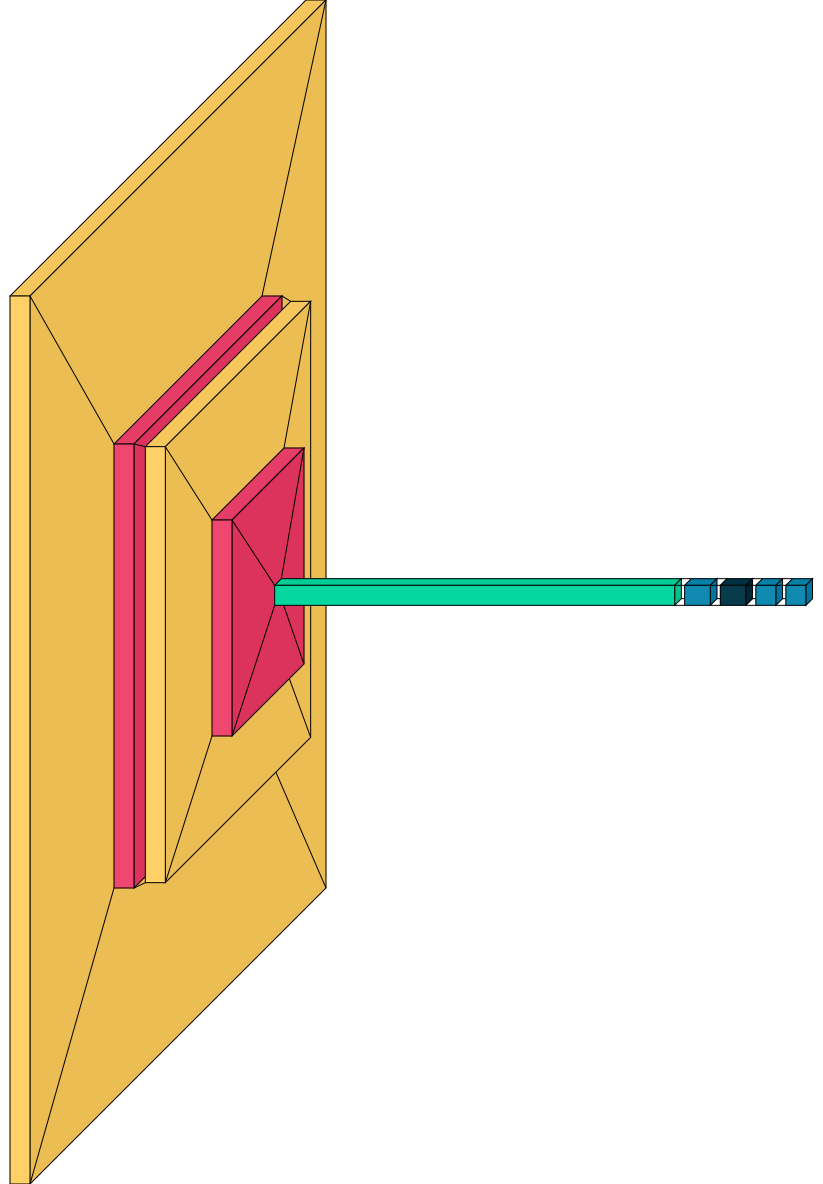

In [ ]:
#visualkeras.layered_view(model.model).show() # display using your system viewer
visualkeras.layered_view(model.model, to_file='output.png') # write to disk